In [21]:
import xarray as xr
from rasterio.enums import Resampling
import rasterio
import matplotlib.pyplot as plt
import numpy as np


In [38]:
data_path = "/Users/fquareng/data/T_2M.nc"
data_path = "/Users/fquareng/data/1h_2D/lffd20101117110000.nz"

In [39]:
ds = xr.open_dataset(data_path, engine="netcdf4")

In [40]:
ds

<xarray.Dataset> Size: 438MB
Dimensions:          (time: 1, bnds: 2, rlon: 1542, rlat: 1542, level1: 61,
                      soil1: 10, windsector: 16)
Coordinates:
  * time             (time) datetime64[ns] 8B 2010-11-17T11:00:00
  * rlon             (rlon) float32 6kB -18.86 -18.84 -18.82 ... 11.94 11.96
  * rlat             (rlat) float32 6kB -14.86 -14.84 -14.82 ... 15.94 15.96
    lon              (rlat, rlon) float32 10MB ...
    lat              (rlat, rlon) float32 10MB ...
    height_2m        float32 4B ...
    height_10m       float32 4B ...
    height_toa       float32 4B ...
  * soil1            (soil1) float32 40B 0.005 0.025 0.07 ... 2.86 5.74 11.5
  * windsector       (windsector) float32 64B 0.0 22.5 45.0 ... 315.0 337.5
Dimensions without coordinates: bnds, level1
Data variables: (12/50)
    time_bnds        (time, bnds) datetime64[ns] 16B ...
    rotated_pole     |S1 1B ...
    vcoord           (level1) float32 244B ...
    wbtemp_13c       float32 4B ...
    soil1_bnds       (soil1, bnds) float32 80B ...
    windsector_bnds  (windsector, bnds) float32 128B ...
    ...               ...
    ATHB_S           (time, rlat, rlon) float32 10MB ...
    ATHD_S           (time, rlat, rlon) float32 10MB ...
    ATHU_S           (time, rlat, rlon) float32 10MB ...
    ALB_RAD          (time, rlat, rlon) float32 10MB ...
    HPBL             (time, rlat, rlon) float32 10MB ...
    HZEROCL          (time, rlat, rlon) float32 10MB ...
Attributes:
    title:           COSMO driven by 4 km COSMO
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-05-29 06:25:08
    history:         Fri May 17 20:30:31 2024: ncks -4 -L 5 --no_abc -O /proj...
    NCO:             netCDF Operators version 5.0.4 (Homepage = http://nco.sf...

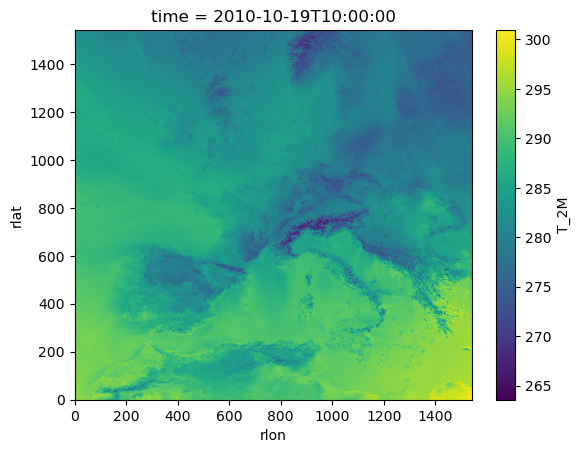

In [33]:
ds.T_2M.sel(time='2010-10-19T10:00:00').plot()

In [56]:
def stitch_tiffs(input_files, output_file):
    # Open the input TIFF files using rasterio
    with rasterio.open(input_files[0]) as src:
        # Get metadata of the first file
        meta = src.meta
        # Read the first file's data
        data = src.read(1)  # Assuming single-band files; adjust if more bands are present
        
    # Loop through the remaining TIFF files and append their data
    for file in input_files[1:]:
        with rasterio.open(file) as src:
            # Read data from current TIFF file
            new_data = src.read(1)  # Assuming single-band files; adjust if more bands are present
            
            # Combine the data along the appropriate axis
            data = np.hstack((data, new_data))  # For horizontal stitching (side by side)
            # data = np.vstack((data, new_data))  # For vertical stitching (one on top of another)

    # Update the metadata for the output file (e.g., width, height, etc.)
    meta.update({
        'count': 1,  # Number of bands (adjust if you have more than 1 band)
        'height': data.shape[0],
        'width': data.shape[1]
    })

    # Write the stitched data to the output TIFF file
    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(data, 1)  # Write to the first band (since we have single-band data)

    print(f"Stitched TIFF saved as: {output_file}")

# Example usage
input_files = [
    '/Users/fquareng/data/output_hh.tif',
    '/Users/fquareng/data/output_hh 2.tif',
    '/Users/fquareng/data/output_hh 3.tif',
]

output_file = '/Users/fquareng/data/europe_dem.tif'  # Path to save the new stitched TIFF

stitch_tiffs(input_files, output_file)

Stitched TIFF saved as: /Users/fquareng/data/europe_dem.tif


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 48728, 'height': 32102, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0008333333333333334, 0.0, -11.000416699999988,
       0.0, -0.0008333333333333334, 61.0954167)}


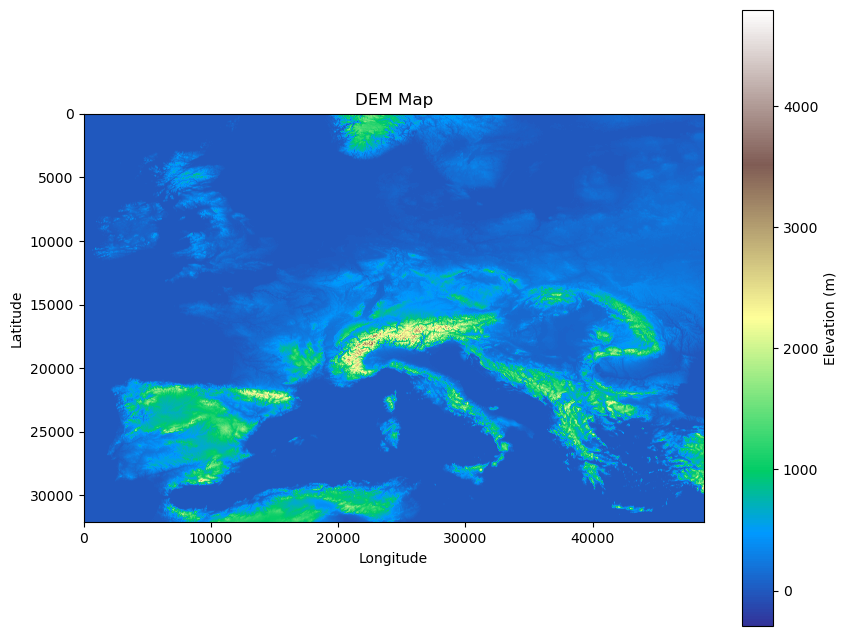

In [57]:
# Open the .tiff file using rasterio
dem_file = '/Users/fquareng/data/europe_dem.tif'
with rasterio.open(dem_file) as src:
    # Read the DEM data
    dem_data = src.read(1)  # Read the first band (assuming the DEM is single-band)

    # Get the metadata for the .tiff
    meta = src.meta
    print(meta)

# Plot the DEM data
plt.figure(figsize=(10, 8))
plt.imshow(dem_data, cmap='terrain', origin='upper')  # 'terrain' colormap for elevation
plt.colorbar(label='Elevation (m)')
plt.title('DEM Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [58]:

def downscale_tiff(input_file, output_file, new_lat, new_lon):
    with rasterio.open(input_file) as src:
        # Read original data and metadata
        data = src.read(1)  # Read the first band (adjust if there are multiple bands)
        transform = src.transform

        # Calculate new resolution based on new_lat and new_lon
        new_height = new_lat
        new_width = new_lon

        # Define the scale factors
        scale_factor_x = src.width / new_width
        scale_factor_y = src.height / new_height

        # Resample data using rasterio's built-in resampling
        resampled_data = src.read(
            out_shape=(src.count, new_height, new_width),  # Adjust dimensions
            resampling=Resampling.bilinear  # Choose the resampling method
        )

        # Update the transform for the new resolution
        new_transform = src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )

        # Update metadata for the output file
        new_meta = src.meta.copy()
        new_meta.update({
            "height": new_height,
            "width": new_width,
            "transform": new_transform
        })

        # Write the downscaled data to a new TIFF file
        with rasterio.open(output_file, "w", **new_meta) as dst:
            dst.write(resampled_data)

    print(f"Downscaled TIFF saved as: {output_file}")

# Example usage
input_file = '/Users/fquareng/data/europe_dem.tif'  # Replace with your file path
output_file = '/Users/fquareng/data/europe_dem_low_res.tif'  # Path for the output file
new_lat = 1542  # Number of points in latitude (height)
new_lon = 1542  # Number of points in longitude (width)

downscale_tiff(input_file, output_file, new_lat, new_lon)

Downscaled TIFF saved as: /Users/fquareng/data/europe_dem_low_res.tif


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1542, 'height': 1542, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.026333765672287075, 0.0, -11.000416699999988,
       0.0, -0.017348681366191096, 61.0954167)}


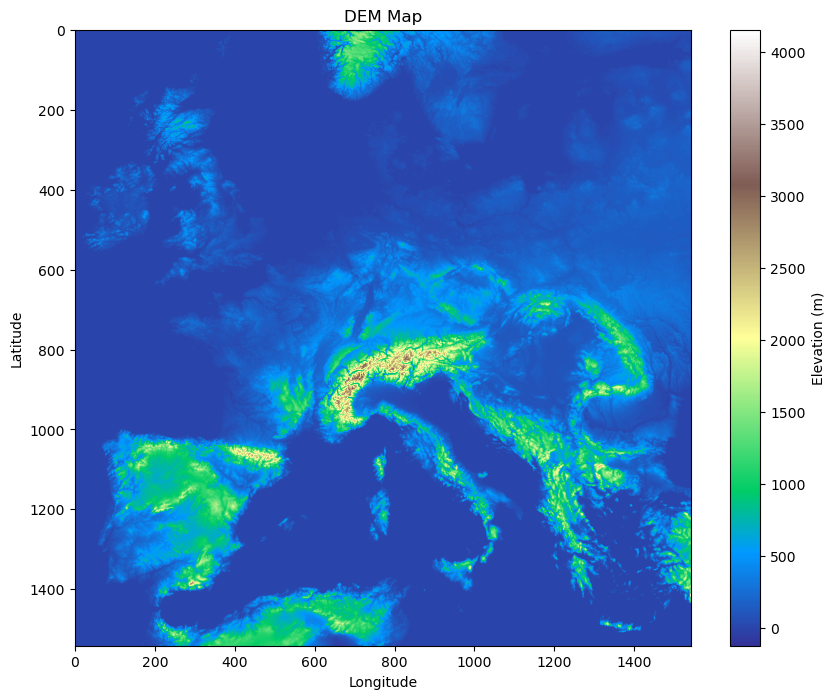

In [59]:
# Open the .tiff file using rasterio
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
with rasterio.open(dem_file) as src:
    # Read the DEM data
    dem_data = src.read(1)  # Read the first band (assuming the DEM is single-band)

    # Get the metadata for the .tiff
    meta = src.meta
    print(meta)

# Plot the DEM data
plt.figure(figsize=(10, 8))
plt.imshow(dem_data, cmap='terrain', origin='upper')  # 'terrain' colormap for elevation
plt.colorbar(label='Elevation (m)')
plt.title('DEM Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [92]:
ds.rlat

<xarray.DataArray 'rlat' (rlat: 1542)> Size: 6kB
array([-14.86    , -14.839999, -14.82    , ...,  15.92    ,  15.94    ,
        15.96    ], dtype=float32)
Coordinates:
  * rlat        (rlat) float32 6kB -14.86 -14.84 -14.82 ... 15.92 15.94 15.96
    height_2m   float32 4B ...
    height_10m  float32 4B ...
    height_toa  float32 4B ...
Attributes:
    standard_name:  grid_latitude
    long_name:      rotated latitude
    units:          degrees

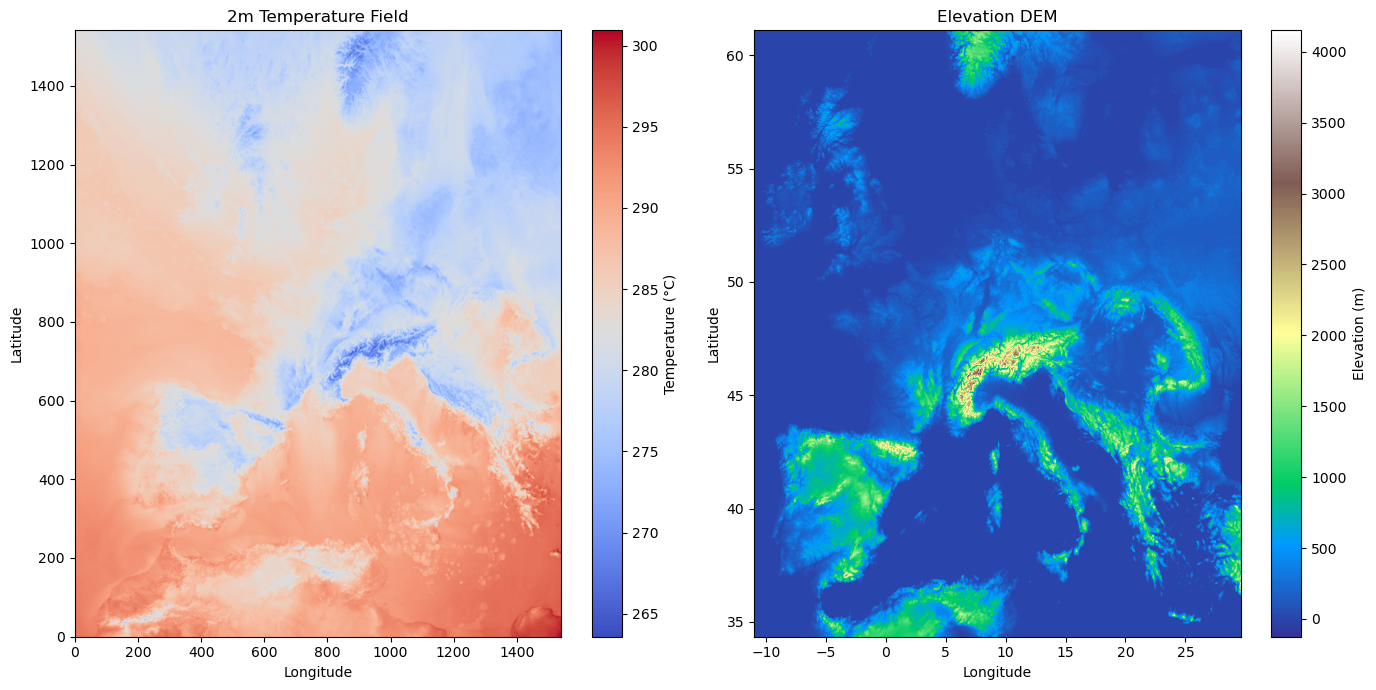

In [102]:
import rasterio
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

def plot_temperature_and_elevation(dem_file, temp_file, variable="T_2M", time_step=0):
    # Load DEM data
    with rasterio.open(dem_file) as dem_src:
        elevation = dem_src.read(1)  # Read the first band
        dem_extent = (
            dem_src.bounds.left,
            dem_src.bounds.right,
            dem_src.bounds.bottom,
            dem_src.bounds.top,
        )

    # Load temperature data
    temp_ds = xr.open_dataset(temp_file)
    temperature = temp_ds[variable].isel(time=time_step).values  # Select the first time step

    # Plot side by side
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    # Plot temperature (flipped)
    im1 = ax[0].imshow(
        temperature,
        origin="lower",
        cmap="coolwarm",
        aspect="auto",
    )
    ax[0].set_title("2m Temperature Field")
    ax[0].set_xlabel("Longitude")
    ax[0].set_ylabel("Latitude")
    plt.colorbar(im1, ax=ax[0], label="Temperature (°C)")

    # Plot elevation
    im2 = ax[1].imshow(
        elevation,
        extent=dem_extent,
        cmap="terrain",
        aspect="auto",
    )
    ax[1].set_title("Elevation DEM")
    ax[1].set_xlabel("Longitude")
    ax[1].set_ylabel("Latitude")
    plt.colorbar(im2, ax=ax[1], label="Elevation (m)")

    plt.tight_layout()
    plt.show()

# Example usage
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
temp_file = '/Users/fquareng/data/T_2M.nc'
plot_temperature_and_elevation(dem_file, temp_file)

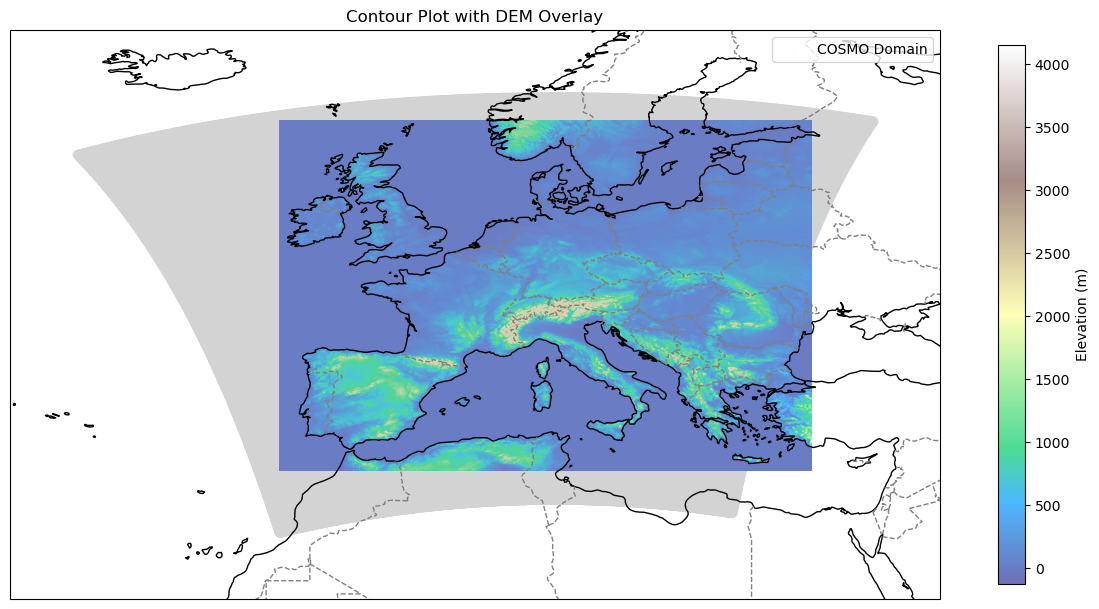

In [133]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
from rasterio.plot import show

def plot_contour_on_map_with_dem(lat_list, lon_list, dem_file, proj=ccrs.PlateCarree()):
    """
    Plot a contour on a Cartopy map showing an area defined by latitude and longitude arrays, 
    and overlay a DEM from a .tiff file.
    
    Parameters:
    - lat_list: List of numpy arrays for latitudes
    - lon_list: List of numpy arrays for longitudes
    - dem_file: Path to the DEM .tiff file
    - proj: Cartopy CRS projection (default: PlateCarree)
    """
    # Merge all latitudes and longitudes into single arrays
    all_lats = np.concatenate(lat_list)
    all_lons = np.concatenate(lon_list)

    # Set up the Cartopy map
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={"projection": proj})
    buffer = 5
    extent = [min(all_lons) - buffer, max(all_lons) + buffer, min(all_lats) - buffer, max(all_lats) + buffer]
    ax.set_extent(extent, crs=proj)

    # Add coastlines and map features
    ax.coastlines(resolution="50m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')
    # ax.add_feature(cfeature.LAND, facecolor="lightgray")

    # Plot the DEM as an image
    with rasterio.open(dem_file) as dem:
        dem_data = dem.read(1)  # Read the first band
        dem_extent = [dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top]
        
        # Plot the DEM using ax.imshow
        img = ax.imshow(
            dem_data,
            extent=dem_extent,
            transform=proj,
            cmap="terrain",
            origin="upper",
            alpha=0.7
        )

    # Add a colorbar for the DEM
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", shrink=0.7, label="Elevation (m)")

    # # Plot the bounding box
    # min_lon, max_lon, min_lat, max_lat = -11.000416699999988, 29.60624996666668, 34.343750033333336, 61.0954167
    # ax.plot(
    #     [min_lon, max_lon, max_lon, min_lon, min_lon],
    #     [min_lat, min_lat, max_lat, max_lat, min_lat],
    #     color="k",
    #     linewidth=2,
    #     transform=proj,
    #     label="Bounding Box"
    # )

    # Add scatter points for the original lat/lon
    ax.scatter(all_lons, all_lats, color="lightgrey", alpha=0.005, label="COSMO Domain", transform=proj)
    ax.legend()

    plt.title("Contour Plot with DEM Overlay")
    plt.show()

# Example usage
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
lat_list = ds.lat.values
lon_list = ds.lon.values

plot_contour_on_map_with_dem(lat_list, lon_list, dem_file)

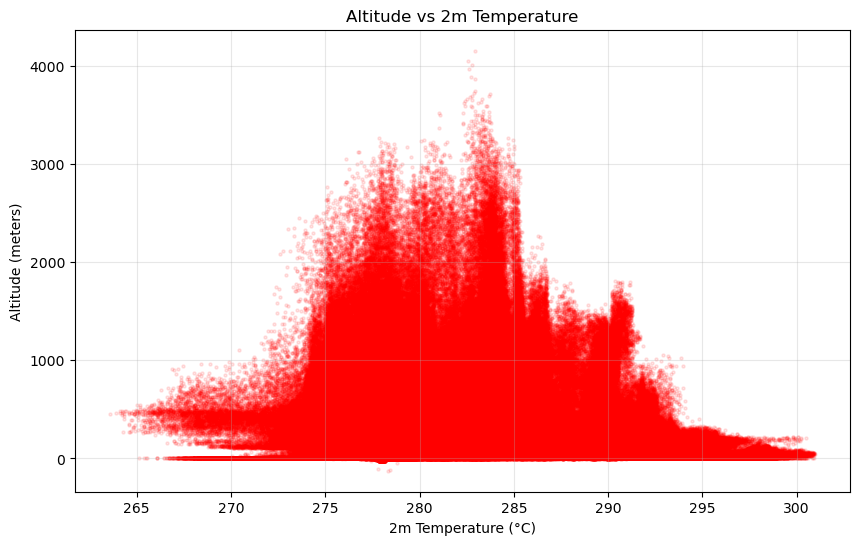

In [66]:
def plot_altitude_vs_temperature(dem_file, temp_file, variable="T_2M", time_step=0):
    # Load DEM data
    with rasterio.open(dem_file) as dem_src:
        altitude = dem_src.read(1)  # Read the first (and usually only) band
        dem_transform = dem_src.transform

    # Load temperature data
    temp_ds = xr.open_dataset(temp_file)
    temperature = temp_ds[variable].isel(time=time_step).values  # Select the first time step

    # Check dimensions match
    if altitude.shape != temperature.shape:
        raise ValueError("Altitude and temperature dimensions do not match. Check input files.")

    # Flatten the 2D grid into 1D arrays
    altitude_flat = altitude.flatten()
    temperature_flat = temperature.flatten()

    # Remove NaN values (common in geospatial data)
    valid_mask = ~np.isnan(altitude_flat) & ~np.isnan(temperature_flat)
    altitude_flat = altitude_flat[valid_mask]
    temperature_flat = temperature_flat[valid_mask]

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(temperature_flat, altitude_flat, s=5, alpha=0.1, c="red")
    plt.title("Altitude vs 2m Temperature")
    plt.ylabel("Altitude (meters)")
    plt.xlabel("2m Temperature (°C)")
    plt.grid(alpha=0.3)
    plt.show()

# Example usage
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
temp_file = '/Users/fquareng/data/T_2M.nc'
plot_altitude_vs_temperature(dem_file, temp_file)

Number of points with altitude > 100 meters: 1001408
Number of points with altitude ≤ 100 meters: 1376356


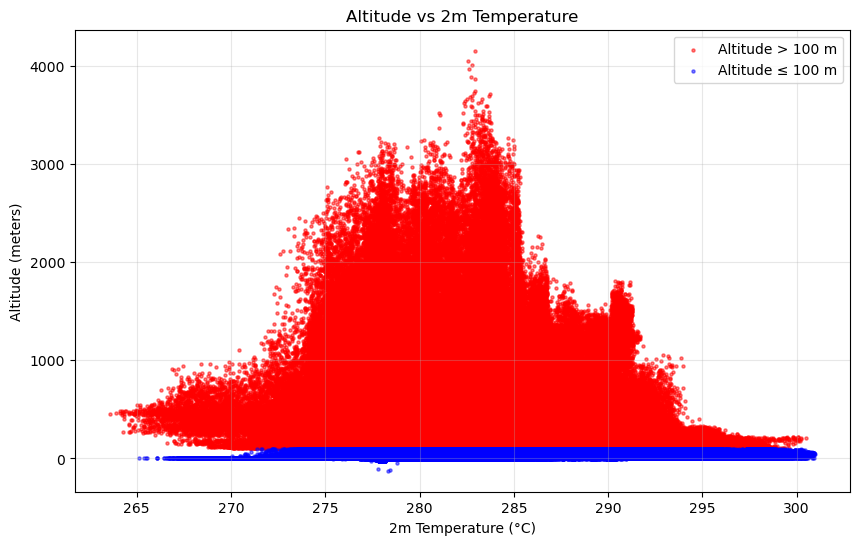

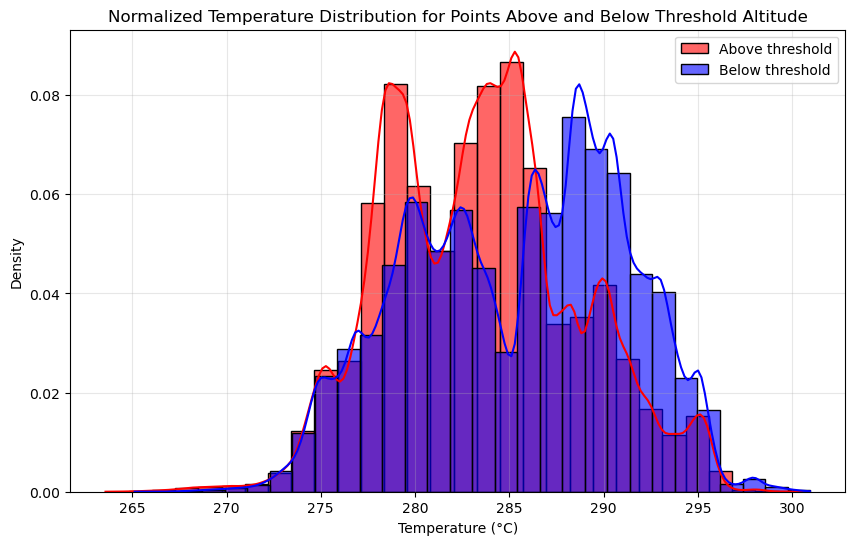

Number of points with altitude > 800 meters: 185647
Number of points with altitude ≤ 800 meters: 2192117


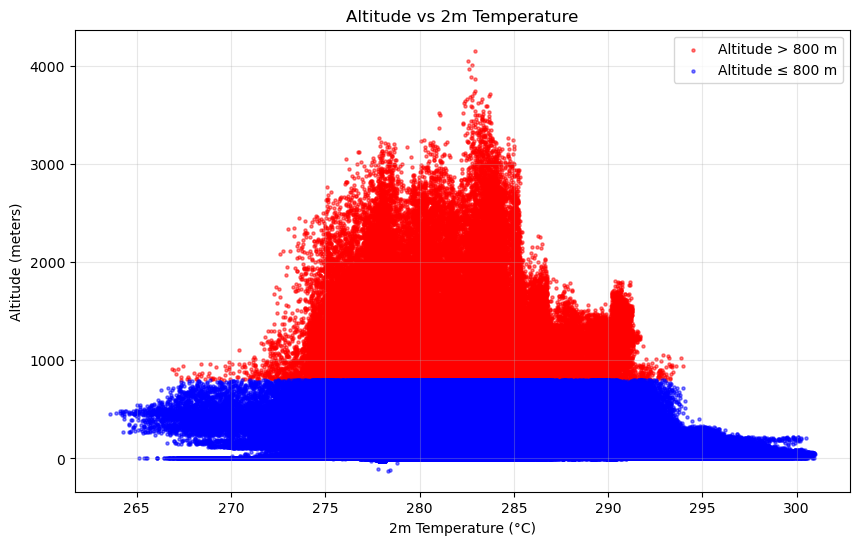

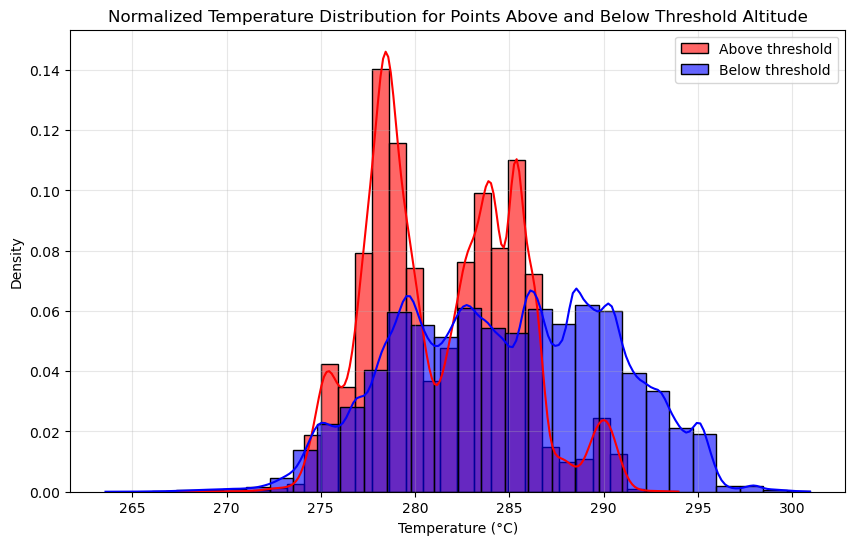

Number of points with altitude > 2000 meters: 10528
Number of points with altitude ≤ 2000 meters: 2367236


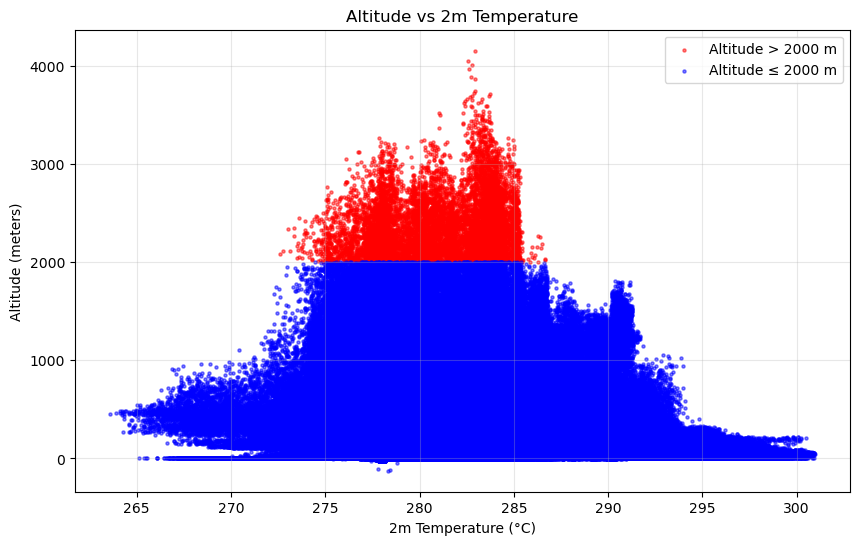

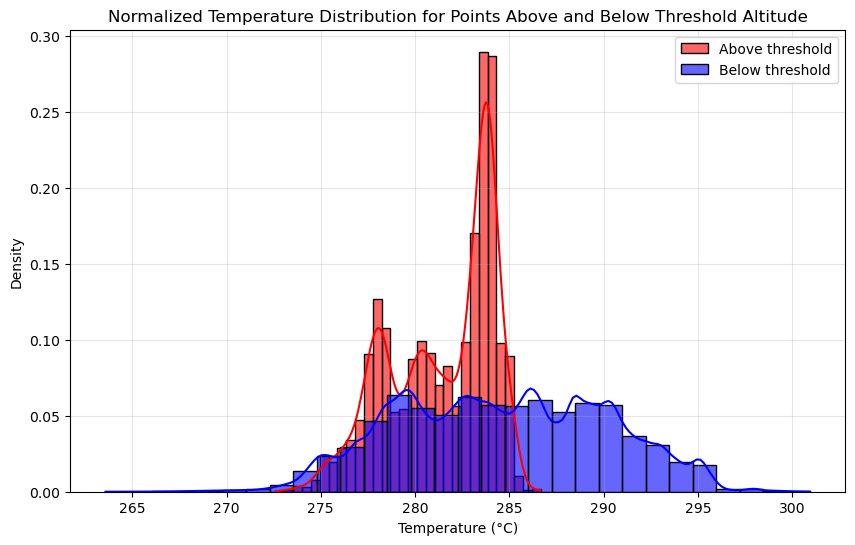

Number of points with altitude > 3000 meters: 390
Number of points with altitude ≤ 3000 meters: 2377374


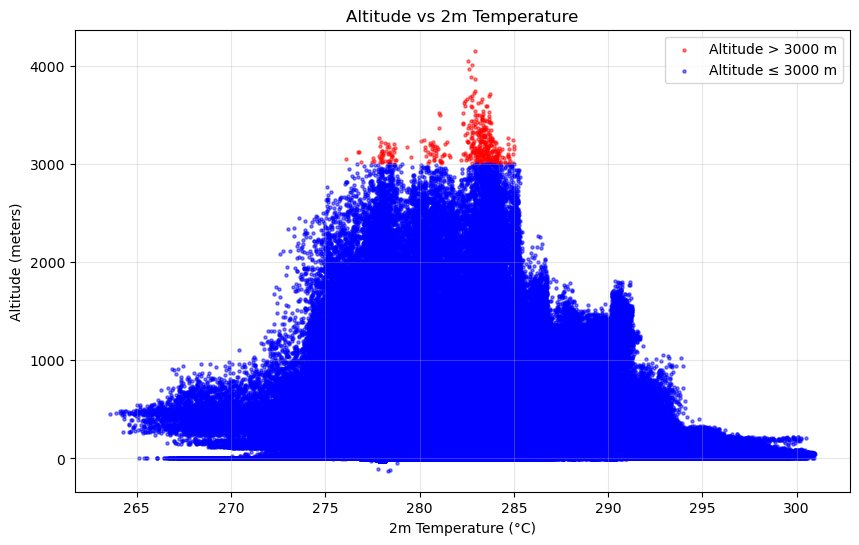

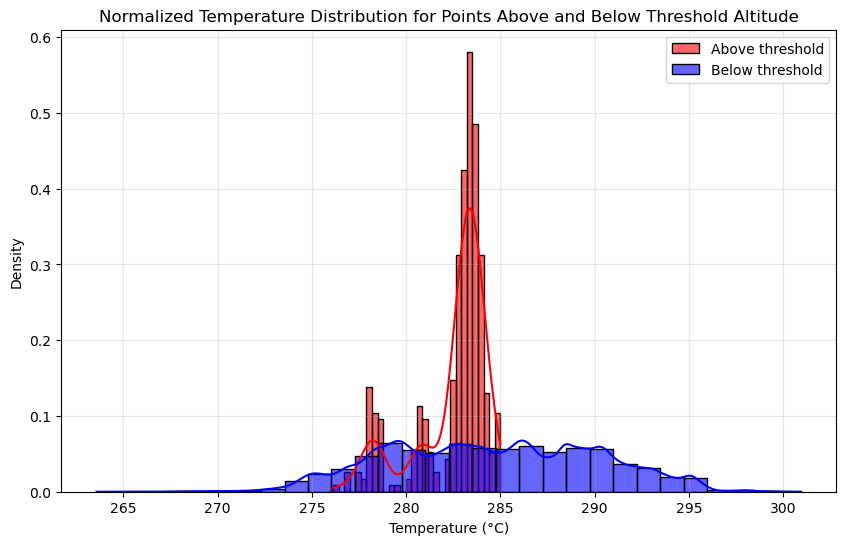

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import xarray as xr
import seaborn as sns

def plot_altitude_vs_temperature(dem_file, temp_file, variable="T_2M", time_step=0, threshold=1000):
    # Load DEM data
    with rasterio.open(dem_file) as dem_src:
        altitude = dem_src.read(1)  # Read the first (and usually only) band
        dem_transform = dem_src.transform

    # Load temperature data
    temp_ds = xr.open_dataset(temp_file)
    temperature = temp_ds[variable].isel(time=time_step).values  # Select the first time step

    # Check dimensions match
    if altitude.shape != temperature.shape:
        raise ValueError("Altitude and temperature dimensions do not match. Check input files.")

    # Flatten the 2D grid into 1D arrays
    altitude_flat = altitude.flatten()
    temperature_flat = temperature.flatten()

    # Remove NaN values (common in geospatial data)
    valid_mask = ~np.isnan(altitude_flat) & ~np.isnan(temperature_flat)
    altitude_flat = altitude_flat[valid_mask]
    temperature_flat = temperature_flat[valid_mask]

    # Create a mask for altitude > threshold
    mask_above_threshold = altitude_flat > threshold

    # Count the number of points above and below the threshold
    num_above_threshold = np.sum(mask_above_threshold)
    num_below_threshold = np.sum(~mask_above_threshold)

    # Print the counts
    print(f"Number of points with altitude > {threshold} meters: {num_above_threshold}")
    print(f"Number of points with altitude ≤ {threshold} meters: {num_below_threshold}")

    # Scatter plot with two colors based on altitude
    plt.figure(figsize=(10, 6))
    
    # Plot points where altitude is above the threshold in one color
    plt.scatter(temperature_flat[mask_above_threshold], altitude_flat[mask_above_threshold], 
                s=5, alpha=0.5, c='red', label=f'Altitude > {threshold} m')
    
    # Plot points where altitude is below or equal to the threshold in another color
    plt.scatter(temperature_flat[~mask_above_threshold], altitude_flat[~mask_above_threshold], 
                s=5, alpha=0.5, c='blue', label=f'Altitude ≤ {threshold} m')

    plt.title("Altitude vs 2m Temperature")
    plt.ylabel("Altitude (meters)")
    plt.xlabel("2m Temperature (°C)")
    plt.grid(alpha=0.3)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

    # Call the function to plot the normalized temperature distribution for points above and below the threshold
    plot_normalized_temperature_distribution(temperature_flat, mask_above_threshold)

def plot_normalized_temperature_distribution(temperature_flat, mask_above_threshold):
    # Filter temperature data for points above and below the threshold
    temperature_above_threshold = temperature_flat[mask_above_threshold]
    temperature_below_threshold = temperature_flat[~mask_above_threshold]

    # Plot distribution (Histogram) with normalized frequency
    plt.figure(figsize=(10, 6))
    
    # Plot the normalized distribution for points above the threshold in red
    sns.histplot(temperature_above_threshold, kde=True, bins=30, color='red', label="Above threshold", stat='density', alpha=0.6)

    # Plot the normalized distribution for points below the threshold in blue
    sns.histplot(temperature_below_threshold, kde=True, bins=30, color='blue', label="Below threshold", stat='density', alpha=0.6)

    plt.title("Normalized Temperature Distribution for Points Above and Below Threshold Altitude")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Density")
    plt.grid(alpha=0.3)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

# Example usage
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
temp_file = '/Users/fquareng/data/T_2M.nc'
plot_altitude_vs_temperature(dem_file, temp_file, threshold=100)
plot_altitude_vs_temperature(dem_file, temp_file, threshold=800)
plot_altitude_vs_temperature(dem_file, temp_file, threshold=2000)
plot_altitude_vs_temperature(dem_file, temp_file, threshold=3000)

In [143]:
import numpy as np
import rasterio
import xarray as xr
import matplotlib.pyplot as plt
from affine import Affine

def select_points_above_altitude(dem_file, temp_file, variable="T_2M", time_step=0, altitude_threshold=1000):
    # Load DEM data
    with rasterio.open(dem_file) as dem_src:
        altitude = dem_src.read(1)  # Read the first (and usually only) band
        dem_transform = dem_src.transform

    # Load temperature data
    temp_ds = xr.open_dataset(temp_file)
    temperature = temp_ds[variable].isel(time=time_step)  # Select the specified time step

    # Check dimensions match
    if altitude.shape != temperature.shape:
        raise ValueError("Altitude and temperature dimensions do not match. Check input files.")

    # Create latitude and longitude arrays from the DEM's affine transform
    rows, cols = np.meshgrid(np.arange(altitude.shape[0]), np.arange(altitude.shape[1]), indexing='ij')
    lon, lat = rasterio.transform.xy(dem_transform, rows, cols)

    # Convert to 2D arrays
    lon = np.array(lon)
    lat = np.array(lat)

    # Flatten the 2D arrays into 1D arrays
    altitude_flat = altitude.flatten()
    temperature_flat = temperature.values.flatten()
    lon_flat = lon.flatten()
    lat_flat = lat.flatten()

    # Remove NaN values (common in geospatial data)
    valid_mask = ~np.isnan(altitude_flat) & ~np.isnan(temperature_flat)
    altitude_flat = altitude_flat[valid_mask]
    temperature_flat = temperature_flat[valid_mask]
    lon_flat = lon_flat[valid_mask]
    lat_flat = lat_flat[valid_mask]

    # Select points above the altitude threshold
    high_altitude_mask = altitude_flat > altitude_threshold
    selected_altitude = altitude_flat[high_altitude_mask]
    selected_temperature = temperature_flat[high_altitude_mask]
    selected_lon = lon_flat[high_altitude_mask]
    selected_lat = lat_flat[high_altitude_mask]

    # Create a new dataset with the selected points
    selected_data = {
        "altitude": selected_altitude,
        "temperature": selected_temperature,
        "longitude": selected_lon,
        "latitude": selected_lat,
    }

    # Optional: Return the data as an xarray Dataset
    selected_ds = xr.Dataset(
        {
            "temperature": (["points"], selected_temperature),
            "altitude": (["points"], selected_altitude),
        },
        coords={
            "longitude": (["points"], selected_lon),
            "latitude": (["points"], selected_lat),
        },
    )

    return selected_ds

# Example usage
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
temp_file = '/Users/fquareng/data/T_2M.nc'
altitude_threshold = 1000  # Threshold in meters

selected_ds = select_points_above_altitude(dem_file, temp_file, altitude_threshold=altitude_threshold)
print(selected_ds)

<xarray.Dataset> Size: 3MB
Dimensions:      (points: 111433)
Coordinates:
    longitude    (points) float64 891kB 6.182 6.656 6.683 ... 3.812 3.839 3.865
    latitude     (points) float64 891kB 61.09 61.09 61.09 ... 34.35 34.35 34.35
Dimensions without coordinates: points
Data variables:
    temperature  (points) float32 446kB 289.6 289.9 289.9 ... 278.0 278.0 278.1
    altitude     (points) float32 446kB 1.042e+03 1.105e+03 ... 1.05e+03
